Image shape: torch.Size([3, 224, 224])
Min/Max pixel values: -1.432913899421692 2.640000104904175


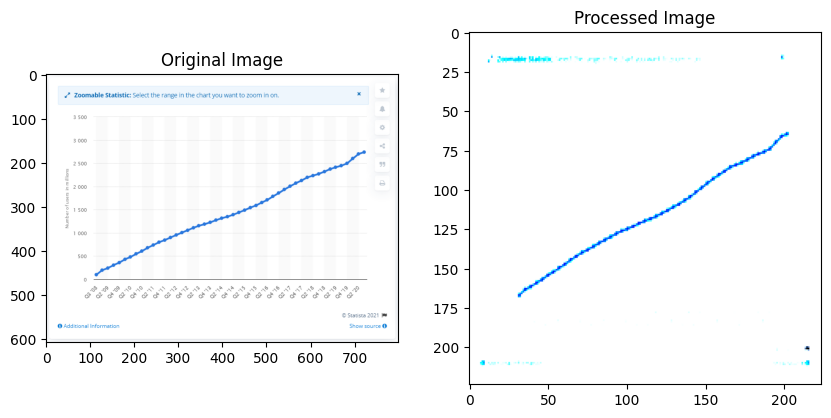

In [1]:
import os
import random
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights

# Define Encoder
class CNNEncoder(nn.Module):
    def __init__(self, embed_size):
        super(CNNEncoder, self).__init__()
        # Load a pre-trained ResNet-50 model using weights
        resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        modules = list(resnet.children())[:-1]  # Remove the final fully connected layer
        self.resnet = nn.Sequential(*modules)
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)  # Reduce dimensions to embed size
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.resnet(images)  # Extract features
        features = features.view(features.size(0), -1)  # Flatten the feature map
        features = self.fc(features)  # Reduce dimensionality
        features = self.relu(features)
        features = self.dropout(features)
        return features

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate Encoder
embed_size = 256
encoder = CNNEncoder(embed_size).to(device)
encoder.eval()  # Set to evaluation mode

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to a consistent size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Using ImageNet normalization stats
])

# Load Train Metadata
train_metadata = pd.read_csv(r'C:\Users\prite\Desktop\graph-to-text\statista_dataset\dataset_copy\train_metadata.csv')  # Replace with your train metadata file path

# Helper function to sample random images based on chart type
def get_random_images_by_chart_type(metadata, chart_type, n_samples=3):
    filtered_data = metadata[metadata['chartType'] == chart_type]
    sampled_data = filtered_data.sample(n=min(n_samples, len(filtered_data)), random_state=42)
    return sampled_data['imgPath'].tolist()

# Chart Types
chart_types = ['column', 'table', 'line', 'pie', 'bar']

# Step 1: Randomly Sample Images from Each Chart Type (Train Set)
random_images = []
for chart_type in chart_types:
    random_images.extend(get_random_images_by_chart_type(train_metadata, chart_type, n_samples=3))

# Step 2: Feature Extraction and Debugging Checks
means = []
stds = []

print("\n=== Encoder Debugging Checks ===\n")
for img_path in random_images:
    # Load image
    if not os.path.exists(img_path):
        print(f"Image path does not exist: {img_path}")
        continue
    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    # Pass through encoder
    with torch.no_grad():
        features = encoder(image)

    # Check if the output shape is as expected
    if features.shape != (1, embed_size):
        print(f"[ERROR] Incorrect output shape for image {img_path}: {features.shape}")
    else:
        print(f"[INFO] Correct output shape for image {img_path}: {features.shape}")

    # Convert tensor to numpy array and analyze
    features_np = features.cpu().numpy().flatten()
    means.append(np.mean(features_np))
    stds.append(np.std(features_np))

    # Check for anomalies in the feature values
    if np.all(features_np == 0):
        print(f"[WARNING] All feature values are zero for image {img_path}.")
    elif np.any(np.isnan(features_np)):
        print(f"[ERROR] NaN values found in features for image {img_path}.")
    else:
        print(f"[INFO] Feature extraction successful for image {img_path}: Mean: {np.mean(features_np):.4f}, Std Dev: {np.std(features_np):.4f}\n")

# Step 3: Feature Distribution Analysis Summary
print("\n=== Summary of Feature Distribution ===\n")
for i, img_path in enumerate(random_images):
    print(f"Image: {img_path} - Mean: {means[i]:.4f}, Std Dev: {stds[i]:.4f}")

# Step 4: Edge Case Testing
print("\n=== Edge Case Testing ===\n")
# Create a random noise image
random_noise_image = np.random.rand(256, 256, 3) * 255
random_noise_image = Image.fromarray(random_noise_image.astype('uint8')).convert("RGB")
noise_image_tensor = transform(random_noise_image).unsqueeze(0).to(device)

# Pass random noise image through encoder
with torch.no_grad():
    noise_features = encoder(noise_image_tensor)

# Convert tensor to numpy array and analyze
noise_features_np = noise_features.cpu().numpy().flatten()
print(f"Random Noise Image - Feature Mean: {np.mean(noise_features_np):.4f}, Std Dev: {np.std(noise_features_np):.4f}")

# Step 5: Plot Feature Vector of One Random Image
random_img_path = random.choice(random_images)
image = Image.open(random_img_path).convert("RGB")
image = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    features = encoder(image)

# Convert tensor to numpy array
features_np = features.cpu().numpy().flatten()

# Plot the feature vector
plt.figure(figsize=(10, 4))
plt.plot(features_np)
plt.title(f"Encoder Feature Vector for Image {os.path.basename(random_img_path)}")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.show()


In [ ]:
# Define RNN Decoder
class RNNDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(RNNDecoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)  # Embedding layer for the tokens
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)  # Fully connected layer to output vocab size
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        # Embed the captions
        captions_embed = self.embed(captions)
        
        # Concatenate image features with the captions (features come first in sequence)
        features = features.unsqueeze(1)  # Add a sequence dimension (batch_size, 1, embed_size)
        inputs = torch.cat((features, captions_embed), dim=1)

        # Pass through LSTM and fully connected layer
        lstm_out, _ = self.lstm(inputs)
        outputs = self.fc(self.dropout(lstm_out))

        return outputs

# Hyperparameters
embed_size = 256
hidden_size = 512
vocab_size = len(vocab)  # You need to define this based on your vocabulary size
num_layers = 1

# Instantiate Decoder
decoder = RNNDecoder(embed_size, hidden_size, vocab_size, num_layers).to(device)
